# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2

split = int(validation_split * data_size)
indices = list(range(data_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: ", epoch)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    batch_accuracy = 0

    for i_step, (x, y) in enumerate(val_loader):
        prediction = model(x)
        predicted_output = torch.argmax(prediction, 1)

        batch_accuracy += torch.sum(y == predicted_output) / y.shape[0]
    
    return batch_accuracy / i_step

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch:  0
Average loss: 1.826604, Train accuracy: 0.410180, Val accuracy: 0.540430
Epoch:  1
Average loss: 1.453835, Train accuracy: 0.584479, Val accuracy: 0.605466
Epoch:  2
Average loss: 1.376604, Train accuracy: 0.619971, Val accuracy: 0.621971


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
    )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch:  0
Average loss: 2.190060, Train accuracy: 0.195151, Val accuracy: 0.201779
Epoch:  1
Average loss: 2.028301, Train accuracy: 0.257585, Val accuracy: 0.327916
Epoch:  2
Average loss: 1.821109, Train accuracy: 0.370798, Val accuracy: 0.404379
Epoch:  3
Average loss: 1.713244, Train accuracy: 0.415179, Val accuracy: 0.425418
Epoch:  4
Average loss: 1.684463, Train accuracy: 0.431048, Val accuracy: 0.434841


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

print("batch normalization before ReLU")

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    torch.nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

print("batch normalization after ReLU")

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(64),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

batch normalization before ReLU
Epoch:  0
Average loss: 2.074128, Train accuracy: 0.311777, Val accuracy: 0.422711
Epoch:  1
Average loss: 1.812466, Train accuracy: 0.459885, Val accuracy: 0.503567
Epoch:  2
Average loss: 1.684371, Train accuracy: 0.526533, Val accuracy: 0.540778
Epoch:  3
Average loss: 1.596514, Train accuracy: 0.563321, Val accuracy: 0.589282
Epoch:  4
Average loss: 1.530444, Train accuracy: 0.586885, Val accuracy: 0.601417
batch normalization after ReLU
Epoch:  0
Average loss: 1.921065, Train accuracy: 0.382845, Val accuracy: 0.542189
Epoch:  1
Average loss: 1.513453, Train accuracy: 0.579719, Val accuracy: 0.627476
Epoch:  2
Average loss: 1.346156, Train accuracy: 0.636078, Val accuracy: 0.655203
Epoch:  3
Average loss: 1.253849, Train accuracy: 0.668225, Val accuracy: 0.690393
Epoch:  4
Average loss: 1.196505, Train accuracy: 0.686704, Val accuracy: 0.694849


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

def train_model_scheduler(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: ", epoch)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(64),
    nn.Linear(64, 10)
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma= .2)

loss_history, train_history, val_history = train_model_scheduler(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 5)

Epoch:  0
Average loss: 1.869860, Train accuracy: 0.413507, Val accuracy: 0.570510
Epoch:  1
Average loss: 1.475209, Train accuracy: 0.596628, Val accuracy: 0.649898
Epoch:  2
Average loss: 1.339778, Train accuracy: 0.651742, Val accuracy: 0.666327
Epoch:  3
Average loss: 1.308102, Train accuracy: 0.664284, Val accuracy: 0.677687
Epoch:  4
Average loss: 1.286049, Train accuracy: 0.671604, Val accuracy: 0.679857


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(val_indices)
    val_data = torch.utils.data.DataLoader(data_train, sampler=sampler)
    
    predictions = []
    ground_truth = []
    for x,y in val_data:
        pred = nn_model(x)
        predictions.append(torch.argmax(pred))
        ground_truth.append(y)
    
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

/tmp/ipykernel_10130/2863498322.py:50: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  assert np.any(np.not_equal(gt, predictions))
/tmp/ipykernel_10130/2863498322.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  assert np.any(np.not_equal(gt, predictions))


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

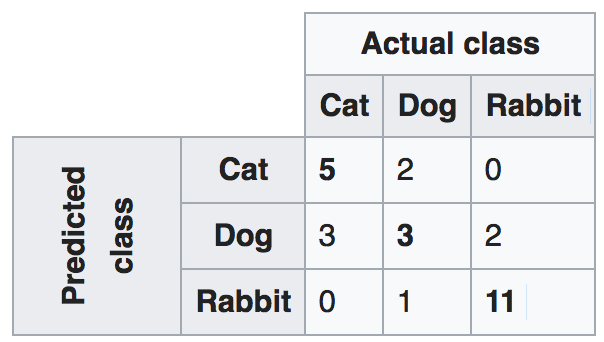

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

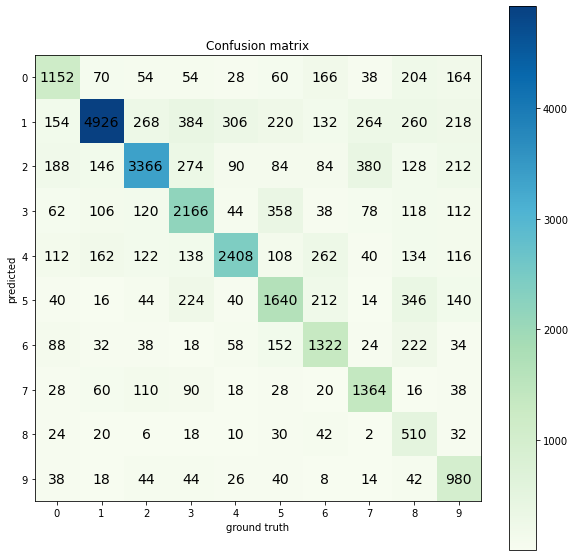

In [11]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10,10), int)
    for i in range(len(predictions)) : confusion_matrix[predictions[i], gt[i]] += 1 
    
    # TODO: Implement filling the prediction matrix
    for i in range(len(predictions)) : confusion_matrix[predictions[i], gt[i]] += 1 
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

/tmp/ipykernel_10130/564844550.py:39: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gt_indexes = np.where(np.array(groud_truth)==gt_class)[0]
/tmp/ipykernel_10130/564844550.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gt_indexes = np.where(np.array(groud_truth)==gt_class)[0]


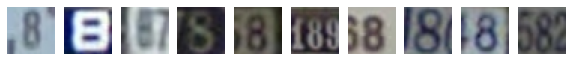

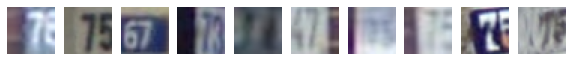

In [36]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    predicted_indexes = np.where(np.array(predictions)==predicted_class)[0]
    gt_indexes = np.where(np.array(groud_truth)==gt_class)[0]
    predicted_gt_indices = np.intersect1d(predicted_indexes,gt_indexes)
    
    indices = np.array(val_indices)[predicted_gt_indices]
    
    visualize_images(indices, data_train_images)
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

### Experiment 1. Оптимизатор и гиперпараметы!

In [51]:
expriment_model_1 = nn.Sequential(
    Flattener(),
    
    nn.Linear(32*32*3, 1024),
    nn.ReLU(inplace=True),
    
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    
    nn.Linear(64, 32),
    nn.ReLU(inplace=True),
    
    nn.Linear(32, 10))


expriment_model_2 = nn.Sequential(
    Flattener(),
    
    nn.Linear(32*32*3, 128),
    nn.ReLU(inplace=True),
    
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    
    nn.Linear(64, 32),
    nn.ReLU(inplace=True),
    
    nn.Linear(32, 10))

expriment_model_3 = nn.Sequential(
    Flattener(),
    
    nn.Linear(32*32*3, 1024),
    nn.ReLU(inplace=True),
    
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    
    nn.Linear(512, 10))

expriment_model_4 = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, 128),
    nn.ReLU(inplace=True),

    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    
    nn.Linear(64, 10)
    )

In [54]:
def SGD(expriment_model):
    best_val_acc = 0

    print("SGD")
    for i in range(5):
        learning_rate = 0.1**np.random.uniform(1,4)
        L2_lambda = 0.1**np.random.uniform(1,4)

        optimizer = optim.SGD(expriment_model.parameters(), lr=learning_rate, weight_decay=L2_lambda)
        loss_history, train_history, val_history = train_model(expriment_model, train_loader, val_loader, loss, optimizer, 5)

        if max(val_history) > best_val_acc:
            print("Best params for now")
            best_optimizer = optimizer
            
    return best_optimizer

In [62]:
def SGD_scheduler(expriment_model):
    best_val_acc = 0

    print("SGD + each i epochs decrease the learning rate step")
    for i in range(5):
        learning_rate = 0.1**np.random.uniform(1,4)
        L2_lambda = 0.1**np.random.uniform(1,4)
        optimizer = optim.SGD(expriment_model.parameters(), lr=learning_rate, weight_decay=L2_lambda)

        epoch_step_size = np.random.randint(2,4)
        step = 0.1**np.random.uniform(1,2) + 0.1**np.random.uniform(1,2)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epoch_step_size, gamma=step)

        loss_history, train_history, val_history = train_model_scheduler(expriment_model, 
                                                                         train_loader, val_loader, 
                                                                         loss, optimizer, scheduler, 5)

        if max(val_history) > best_val_acc:
            print("Best params for now")

            best_optimizer = optimizer
            best_scheduler = scheduler

    return best_optimizer, best_scheduler

comment: very good also to implement SGD with momentum, but I'm so lazzzzy

In [63]:
def Adam(expriment_model):
    best_val_acc = 0

    print("Adam")
    for i in range(5):
        learning_rate = 0.1**np.random.uniform(1,4)
        # betas = np.random.uniform(0.9, 0.999)

        optimizer = optim.Adam(expriment_model.parameters(), lr=learning_rate)
        loss_history, train_history, val_history = train_model(expriment_model, train_loader, val_loader,
                                                               loss, optimizer, 5)

        if max(val_history) > best_val_acc:
            print("Best params for now")
            best_optimizer = optimizer

    return best_optimizer

In [55]:
SGD_best_optimizer_1 = SGD(expriment_model_1)
SGD_best_optimizer_3 = SGD(expriment_model_3)
SGD_best_optimizer_2 = SGD(expriment_model_2)
SGD_best_optimizer_4 = SGD(expriment_model_4)

SGD
Epoch:  0
Average loss: 2.237242, Train accuracy: 0.189110, Val accuracy: 0.190442
Epoch:  1
Average loss: 2.236514, Train accuracy: 0.189110, Val accuracy: 0.190442
Epoch:  2
Average loss: 2.236478, Train accuracy: 0.189110, Val accuracy: 0.190425
Epoch:  3
Average loss: 2.236444, Train accuracy: 0.189110, Val accuracy: 0.190442
Epoch:  4
Average loss: 2.236427, Train accuracy: 0.189110, Val accuracy: 0.190448
Best params for now
Epoch:  0
Average loss: 2.236236, Train accuracy: 0.189110, Val accuracy: 0.190465
Epoch:  1
Average loss: 2.236176, Train accuracy: 0.189110, Val accuracy: 0.190425
Epoch:  2
Average loss: 2.236195, Train accuracy: 0.189110, Val accuracy: 0.190465
Epoch:  3
Average loss: 2.236202, Train accuracy: 0.189110, Val accuracy: 0.190448
Epoch:  4
Average loss: 2.236235, Train accuracy: 0.189110, Val accuracy: 0.190448
Best params for now
Epoch:  0
Average loss: 2.236127, Train accuracy: 0.189110, Val accuracy: 0.190425
Epoch:  1
Average loss: 2.236163, Train acc

In [64]:
SGD_scheduler_best_optimizer_1 = SGD_scheduler(expriment_model_1)
SGD_scheduler_best_optimizer_3 = SGD_scheduler(expriment_model_3)
SGD_scheduler_best_optimizer_2 = SGD_scheduler(expriment_model_2)
SGD_scheduler_best_optimizer_4 = SGD_scheduler(expriment_model_4)

SGD + each i epochs decrease the learning rate step
Epoch:  0
Average loss: 2.238417, Train accuracy: 0.189110, Val accuracy: 0.190442
Epoch:  1
Average loss: 2.238223, Train accuracy: 0.189110, Val accuracy: 0.190413
Epoch:  2
Average loss: 2.238185, Train accuracy: 0.189110, Val accuracy: 0.190471
Epoch:  3
Average loss: 2.238132, Train accuracy: 0.189110, Val accuracy: 0.190413
Epoch:  4
Average loss: 2.238133, Train accuracy: 0.189110, Val accuracy: 0.190442
Best params for now
Epoch:  0
Average loss: 2.237329, Train accuracy: 0.189110, Val accuracy: 0.190407
Epoch:  1
Average loss: 2.236501, Train accuracy: 0.189110, Val accuracy: 0.190506
Epoch:  2
Average loss: 2.236299, Train accuracy: 0.189110, Val accuracy: 0.190425
Epoch:  3
Average loss: 2.236275, Train accuracy: 0.189110, Val accuracy: 0.190431
Epoch:  4
Average loss: 2.236298, Train accuracy: 0.189110, Val accuracy: 0.190448
Best params for now
Epoch:  0
Average loss: 2.236278, Train accuracy: 0.189110, Val accuracy: 0.19

In [65]:
Adam_best_optimizer_1 = Adam(expriment_model_1)
Adam_best_optimizer_3 = Adam(expriment_model_3)
Adam_best_optimizer_2 = Adam(expriment_model_2)
Adam_best_optimizer_4 = Adam(expriment_model_4)

Adam
Epoch:  0
Average loss: 2.236164, Train accuracy: 0.189110, Val accuracy: 0.190471
Epoch:  1
Average loss: 2.236173, Train accuracy: 0.189110, Val accuracy: 0.190454
Epoch:  2
Average loss: 2.236206, Train accuracy: 0.189110, Val accuracy: 0.190413
Epoch:  3
Average loss: 2.236176, Train accuracy: 0.189110, Val accuracy: 0.190425
Epoch:  4
Average loss: 2.236154, Train accuracy: 0.189110, Val accuracy: 0.190419
Best params for now
Epoch:  0
Average loss: 2.238391, Train accuracy: 0.189110, Val accuracy: 0.190448
Epoch:  1
Average loss: 2.238895, Train accuracy: 0.189110, Val accuracy: 0.190448
Epoch:  2
Average loss: 2.238560, Train accuracy: 0.189110, Val accuracy: 0.190460
Epoch:  3
Average loss: 2.238898, Train accuracy: 0.189110, Val accuracy: 0.190413
Epoch:  4
Average loss: 2.238529, Train accuracy: 0.188667, Val accuracy: 0.190442
Best params for now
Epoch:  0
Average loss: 2.236462, Train accuracy: 0.189110, Val accuracy: 0.190431
Epoch:  1
Average loss: 2.236216, Train ac